In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import sys
import logging
from logging.config import dictConfig
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import collections as cl
import multiprocessing

from numba import jit

import pgenlib as pg

In [3]:
logging_config = dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
)
dictConfig(logging_config)

In [4]:
logger_nb = logging.getLogger('notebook')

In [5]:
logger_nb.info('hello')

2017-06-25 15:45:49,375 notebook     INFO     hello


In [6]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'
pgen_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg.log'
pgen_f = '{}{}.pgen'.format(data_dir, pgen_log[:-4])
block_bed_f = '{}{}.bed'.format(data_dir, block_log[:-4])

In [7]:
block_bed = pd.read_csv(block_bed_f, sep='\t', names=['chrom', 'chromStart', 'chromEnd', 'name'])
block_bed['bim_interval'] = block_bed.name.map(lambda x: [int(pos) for pos in x.split(':')])

In [8]:
block_bed.head()

,chrom,chromStart,chromEnd,name,bim_interval
0,chr20,61097,94952,0:86,"[0, 86]"
1,chr20,94952,266792,86:938,"[86, 938]"
2,chr20,266792,288776,938:1027,"[938, 1027]"
3,chr20,288776,344631,1027:1270,"[1027, 1270]"
4,chr20,344631,346676,1270:1277,"[1270, 1277]"


In [9]:
def read_alleles_block(pgen_f, block_df, block_id):
    """wrapper function of pgen.PgenReader.read_alleles_range for a LD block"""
    bim_interval = block_df.bim_interval[block_id]
    with pg.PgenReader(pgen_f) as pgr:
        buf_ndary = np.zeros(
            (bim_interval[1] - bim_interval[0], pgr.get_raw_sample_ct() * 2), 
            dtype=np.int32
        )
        pgr.read_alleles_range(bim_interval[0], bim_interval[1], buf_ndary)
    return buf_ndary

In [10]:
def filter_missing_alleles(geno):
    return geno[:, np.sum(geno == -9, axis = 0) == 0]

In [11]:
def count_alleles_freq(geno):
    tuples = [tuple(1 - geno[:, hap])
              for hap in range(geno.shape[1])]
    return cl.Counter(tuples)

In [12]:
def prior_count(pgen_f, block_df, block_id):
    logger_cnt = logging.getLogger('prior_count')
    cnt = count_alleles_freq(
        filter_missing_alleles(
            read_alleles_block(pgen_f, block_df, block_id)
        )
    )    
    logger_cnt.info(
        'block {:3d} {} bytes'.format(block_id, sys.getsizeof(cnt))
    )    
    return cnt    

In [13]:
cnts = [prior_count(pgen_f, block_bed, block_id) 
        for block_id in range(10)]

2017-06-25 15:45:55,522 prior_count  INFO     block   0 196904 bytes
2017-06-25 15:45:58,137 prior_count  INFO     block   1 786728 bytes
2017-06-25 15:45:59,651 prior_count  INFO     block   2 786728 bytes
2017-06-25 15:46:01,450 prior_count  INFO     block   3 786728 bytes
2017-06-25 15:46:02,331 prior_count  INFO     block   4 3368 bytes
2017-06-25 15:46:03,959 prior_count  INFO     block   5 786728 bytes
2017-06-25 15:46:05,331 prior_count  INFO     block   6 196904 bytes
2017-06-25 15:46:07,377 prior_count  INFO     block   7 3146024 bytes
2017-06-25 15:46:08,662 prior_count  INFO     block   8 786728 bytes
2017-06-25 15:46:09,518 prior_count  INFO     block   9 12584 bytes


In [14]:
count_f='{}.pkl'.format(block_bed_f[:-4])
count_f

'/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.pkl'

In [15]:
pickle.dump(count_f, open(count_f, 'wb'), protocol=2)

In [18]:
!ls -lh $count_f

-rw-rw----+ 1 ytanigaw mrivas 165 Jun 24 16:32 /oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.pkl


In [15]:
cnts = [prior_count(pgen_f, block_bed, block_id) 
        for block_id in range(100)]

2017-06-24 16:10:48,850 prior_count  INFO     block   0 196904 bytes
2017-06-24 16:10:51,609 prior_count  INFO     block   1 786728 bytes
2017-06-24 16:10:53,320 prior_count  INFO     block   2 786728 bytes
2017-06-24 16:10:55,328 prior_count  INFO     block   3 786728 bytes
2017-06-24 16:10:56,121 prior_count  INFO     block   4 3368 bytes
2017-06-24 16:10:57,880 prior_count  INFO     block   5 786728 bytes
2017-06-24 16:10:59,446 prior_count  INFO     block   6 196904 bytes
2017-06-24 16:11:01,646 prior_count  INFO     block   7 3146024 bytes
2017-06-24 16:11:03,049 prior_count  INFO     block   8 786728 bytes
2017-06-24 16:11:03,998 prior_count  INFO     block   9 12584 bytes
2017-06-24 16:11:06,277 prior_count  INFO     block  10 3146024 bytes
2017-06-24 16:11:07,044 prior_count  INFO     block  11 3368 bytes
2017-06-24 16:11:08,750 prior_count  INFO     block  12 3146024 bytes
2017-06-24 16:11:10,587 prior_count  INFO     block  13 196904 bytes
2017-06-24 16:11:13,508 prior_count 

In [ ]:
cnts = [prior_count(pgen_f, block_bed, block_id) 
        for block_id in range(len(block_bed))]

2017-06-24 16:14:24,612 prior_count  INFO     block   0 196904 bytes
2017-06-24 16:14:27,493 prior_count  INFO     block   1 786728 bytes
2017-06-24 16:14:29,278 prior_count  INFO     block   2 786728 bytes
2017-06-24 16:14:31,372 prior_count  INFO     block   3 786728 bytes
2017-06-24 16:14:32,164 prior_count  INFO     block   4 3368 bytes
2017-06-24 16:14:34,015 prior_count  INFO     block   5 786728 bytes
2017-06-24 16:14:35,743 prior_count  INFO     block   6 196904 bytes
2017-06-24 16:14:38,134 prior_count  INFO     block   7 3146024 bytes
2017-06-24 16:14:39,600 prior_count  INFO     block   8 786728 bytes
2017-06-24 16:14:40,635 prior_count  INFO     block   9 12584 bytes
2017-06-24 16:14:42,794 prior_count  INFO     block  10 3146024 bytes
2017-06-24 16:14:43,581 prior_count  INFO     block  11 3368 bytes
2017-06-24 16:14:45,340 prior_count  INFO     block  12 3146024 bytes
2017-06-24 16:14:47,220 prior_count  INFO     block  13 196904 bytes
2017-06-24 16:14:50,355 prior_count 

In [28]:
len(block_bed)

642

In [ ]:
genos = [read_alleles_block(pgen_f, block_bed, block_id) 
         for block_id in range(642)]

In [16]:
geno_0.shape

(86, 224676)

In [9]:
geno_0 = read_alleles_block(pgen_f, block_bed, 0)

In [10]:
geno_filtered_0 = filter_missing_alleles(geno_0)

In [11]:
c_0 = count_alleles_freq(geno_filtered_0)

In [12]:
d_0 = dict(c_0)

In [15]:
for item in [geno_0, geno_filtered_0, c_0, d_0]:
    print(sys.getsizeof(item))

77288656
112
196904
393496


117866 individuals; 5144 unique haplotypes. Top 10 common haplotypes are:
[ '11111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111110111111101110111111111111011111111111110111111111111111111111111'
 '11111111111111111111111111111011111111111111111101111111111111111111111111111111111111'
 '11111111111111111111111111111111111111111111111011111111111110111111111111111111111111'
 '11111111111111111111110111111101111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111011111111111111111111111111111111111111111111111111111111'
 '11111111111111011111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111101111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111101111111111111111011111111111110111111111111111111111111'
 '11111111111111111111011111111011111111111111111111111111111111111111111111111111111111']
[17919, 3388, 3105, 3013

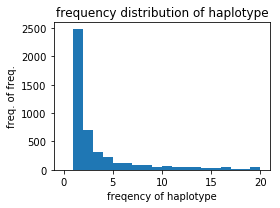

In [27]:
debug_dump_count(c_0)

In [23]:
geno_0.shape, geno_filtered_0.shape

((86, 224676), (86, 117866))

In [9]:
geno = geno_0

In [10]:
geno_isMissing = geno == -9

In [11]:
np.sum(np.sum(geno_isMissing, axis = 0) == 0)

117866

In [13]:
geno.shape

(86, 224676)

In [14]:
len(np.sum(geno_isMissing, axis = 0) == 0)

224676

In [17]:
geno_filtered = geno[:, np.sum(geno == -9, axis = 0) == 0]

In [18]:
geno_filtered.shape

(86, 117866)

In [14]:
def read_haplotype_freq(pgen_f, block_df, block_id):
    """read haplotype frequency of a given block from a pgen file"""
    bim_interval = block_df.bim_interval[block_id]
    with pg.PgenReader(pgen_f) as pgr:
        buf_ndary = np.zeros(
            (bim_interval[1] - bim_interval[0], pgr.get_raw_sample_ct() * 2), 
            dtype=np.int32
        )
        pgr.read_alleles_range(bim_interval[0], bim_interval[1], buf_ndary)
    #buf_ndary[buf_ndary == -9] = 0
    buf_tpls = [tuple(1 - buf_ndary[:, hap]) for hap in range(buf_ndary.shape[1])]
    return cl.Counter(buf_tpls), buf_ndary

In [26]:
def debug_dump_count(c):
    print('{} individuals; {} unique haplotypes. Top 10 common haplotypes are:'.format(sum(c.values()), len(c.values())))
    print(np.array([''.join([str(x) for x in c.most_common()[i][0]]) for i in range(10)]))    
    print([c.most_common()[i][1] for i in range(10)])
#     plt.hist(np.array(c.values())[np.array(c.values()) <= 20], bins=range(21))
    freq=np.array(c.values())
    fig = plt.figure(figsize=(4, 3))
    gs = gridspec.GridSpec(1, 1)
    axs = [fig.add_subplot(ss) for ss in gs]
    axs[0].hist(freq[freq <= 20], bins=range(21))
    axs[0].set_xlabel('freqency of haplotype')
    axs[0].set_ylabel('freq. of freq.')
    axs[0].set_title('frequency distribution of haplotype')
#     fig.suptitle('')
    gs.tight_layout(fig, rect=[0, 0, 1, 1])
#     fig.savefig('./fig.png')

In [15]:
c0, c0_nd = read_haplotype_freq(pgen_f, block_bed, 0)

In [17]:
c0_nd_mis = [c0_nd == -9]

In [ ]:
c0_nd_mis = 

224676 individuals; 30236 unique haplotypes. Top 10 common haplotypes are:
[ '11111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111011111110111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111111111111111111111111111101111111111111011111111111111111'
 '11111111111111111111111111111101111111111111111111111110111111111111111111111111111111'
 '11111111111111111111111111111110111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111011111110111011111001111111111101111111111111011111111111111111'
 '11111111111111101111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111101111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111111111111111111111111110111111111111111111111111111111111'
 '11111111111111111111111111111111111111111011111111111111111111111111111111111111111111']
[31555, 5764, 4331, 403

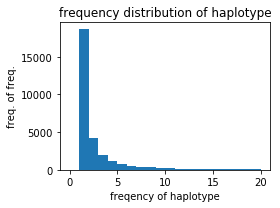

In [9]:
debug_dump_count(c0)

In [10]:
c2 = read_haplotype_freq(pgen_f, block_bed, 2)

224676 individuals; 19835 unique haplotypes. Top 10 common haplotypes are:
['1111111111111111111111111111111111111111111111111111111111111111111111'
 '1111111111111111101111011111101001111111111111111001111111111111101111'
 '0000101000001010110011111110111111100100101111111111101111001110110011'
 '1111111111111111111111111111111111111111111111110111111111111111111111'
 '1111111111111111111111111111111111111111111111111111101111101111110011'
 '1111111111111111111111111111111111111111111111111111111111111110111111'
 '1111111111111111111111111111111111111111111111111001111111111111101111'
 '0000101000001010100011011110101001100100101111111001101111001110100011'
 '1111111111111111101111011111101001111111111111110001111111111111101111'
 '1111111111111111101111011111101001111111111111111111111111111111111111']
[31830, 5944, 5797, 4455, 4060, 3225, 3221, 3213, 2892, 2825]


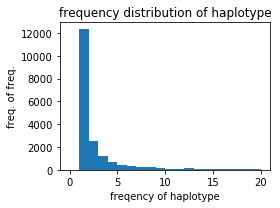

In [11]:
debug_dump_count(c2)

In [12]:
c3 = read_haplotype_freq(pgen_f, block_bed, 3)

224676 individuals; 131281 unique haplotypes. Top 10 common haplotypes are:
[ '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111'
 '1111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '111111111111111111111011011111111111111111111111111111111111

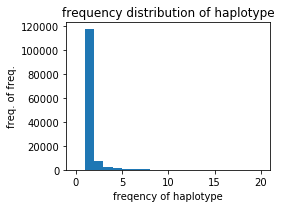

In [13]:
debug_dump_count(c3)